<a href="https://colab.research.google.com/github/aclightbody/MIoT_Project/blob/main/Project_ESP32_MPU6050_DMP6/Scripts/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training is much faster using GPU acceleration. Before you proceed, ensure you are using a GPU runtime by going to **Runtime -> Change runtime type** and selecting **GPU**. Training will take around 5 minutes on a GPU runtime.

In [1]:
# Clone repository from GitHub
!git clone https://github.com/aclightbody/MIoT_Project.git

fatal: destination path 'MIoT_Project' already exists and is not an empty directory.


In [2]:
import csv
import pandas
import numpy
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# https://stackoverflow.com/questions/55424906/building-svm-with-tensorflows-linearclassifier-and-pandas-dataframes
# https://aiplanet.com/notebooks/2418/binthamza/svm-classification-with-tfkeras-model
# https://stackoverflow.com/questions/55424906/building-svm-with-tensorflows-linearclassifier-and-pandas-dataframes
# https://www.kaggle.com/code/shadesh/svm-classification-using-tensorflow-and-keras

cwd = os.getcwd()
print(cwd)

path = '/content/MIoT_Project/Project_ESP32_MPU6050_DMP6/Data'
dataDrop = pandas.read_csv(path + "/FeatureExtractDrop.csv").values
dataWalk = pandas.read_csv(path + "/FeatureExtractWalk.csv").values

/content


x.shape: (100, 2)
y.shape: (100,)


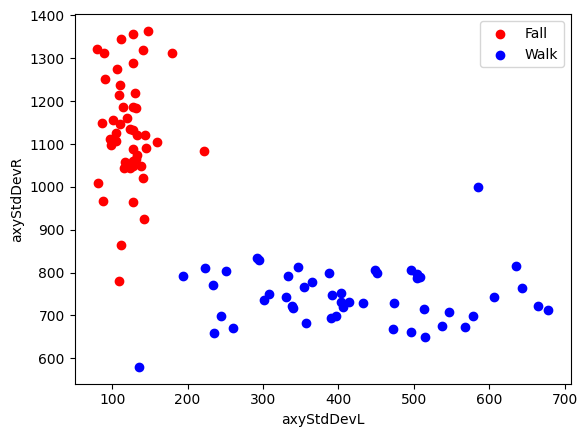

In [3]:
# Features
x = dataDrop[:, 1:]
x = numpy.append(x,dataWalk[:,1:], axis=0)

# Labels
y = dataDrop[:, 0]
y = numpy.append(y,dataWalk[:,0], axis=0)

print("x.shape: " + str(x.shape))
print("y.shape: " + str(y.shape))

# plt.scatter(x[:,0], x[:,1], c=y, cmap=plt.cm.Set1)
plt.scatter(dataDrop[:,1], dataDrop[:,2], c='red', label='Fall')
plt.scatter(dataWalk[:,1], dataWalk[:,2], c='blue', label='Walk')
plt.xlabel("axyStdDevL")
plt.ylabel("axyStdDevR")
plt.legend(loc="upper right")
plt.show()

In [4]:
def get_model():
    #Linear SVM model
    model = tf.keras.Sequential()
    # Metric: is a function to assess model performance. Similar to loss functions, except that the results from evaluating a metric are not used when training the model. Note that you may use any loss function as a metric.
    # Optimizer: adam is a commonly used one. Learning rate: step size when adjusting paramters in model (usually 0.001 to 0.1). Larger learning rate reduces iterations but reduces accuracy, smaller rate gives higher accuracy and more iterations. https://stackoverflow.com/questions/59737875/keras-change-learning-rate
    # Dense layer of 1 means that this layer has one neuron (unit). Since only one layer (output layer) is being added with one neuron, it's linear.
    # Activation function: mathematical function applied to the neuron output in a neural layer. These are used to introduce non-linearity in a neural network. Linear (pass through): input unmodified. https://keras.io/api/layers/activations/.
    # Kernel regularizer: Typical values for the regularisation parameters are 1 to 10, 10 being default. https://keras.io/api/layers/regularizers/. L1 and L2 regularizers have default of 0.01. The L2 regularization penalty is computed as: loss = l2 * reduce_sum(square(x)).Kernel regularizer tries to reduce the weights (excluding bias). https://stats.stackexchange.com/questions/383310/what-is-the-difference-between-kernel-bias-and-activity-regulizers-and-when-t
    # Loss: Hinge loss is equivalent to slack variable. Custom loss function used for hinge loss https://keras.io/api/losses/. https://keras.io/api/losses/hinge_losses/.
    # Kernel: linear, polynomial, guassian, sigmoid, etc
    optmzr = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.add(tf.keras.layers.Dense(1, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(1)))
    model.compile(optimizer=optmzr, loss=tf.keras.losses.Hinge(), metrics=["accuracy"])
    return model

model = get_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [5]:
history = model.fit(x, y, epochs=100, verbose=False)
print("Finished training the model")

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0000e+00 - loss: 306.3804
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 260.7094 
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 264.1399 
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 235.0227 
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 217.2311 
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 174.0694 
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 162.4206 
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 126.2906 
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 112.6785 
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 96.4932  
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 65.6389 
Epoch 12/1

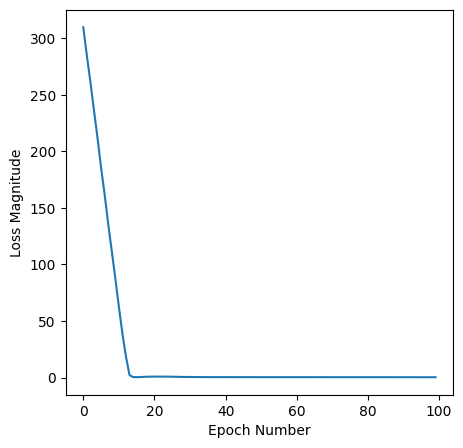

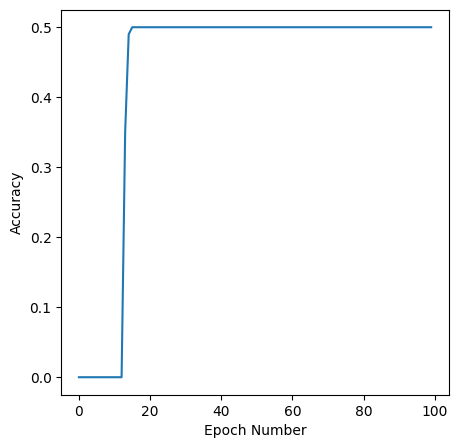

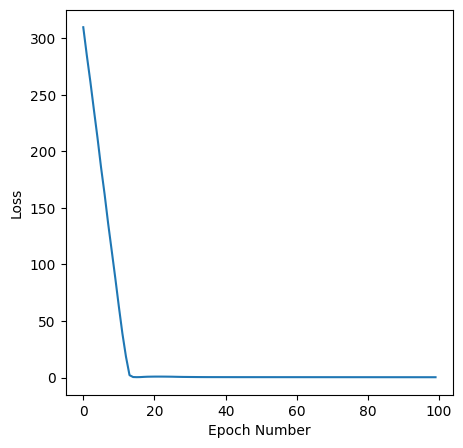

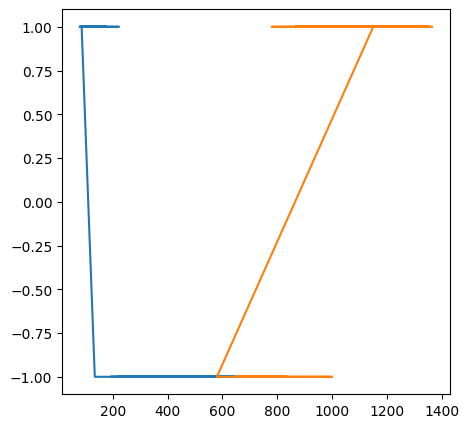

In [10]:
accuracy = history.history['accuracy']
# val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
# val_loss = history.history['val_loss']

plt.figure(figsize=(5, 5))
plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.plot(history.history['loss'])

plt.figure(figsize=(5, 5))
plt.plot(accuracy, label='Training Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')

plt.figure(figsize=(5, 5))
plt.plot(loss, label='Training Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')

plt.figure(figsize=(5, 5))
plt.plot(x, y) # model.layers[0].kernel.numpy(), -model.layers[0].bias.numpy()

# model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
# loss, acc = model.evaluate(test_data)
# pred = np.argmax(model.predict(test_data), axis=1)
# confusion = tf.math.confusion_matrix(labels=tf.constant(test_labels), predictions=tf.constant(pred), num_classes=4)
# print(confusion)
# print("Loss {}, Accuracy {}".format(loss, acc))

# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


# plot(X, Y, W=model.weight.t().detach().numpy(), b=-model.bias.detach().numpy())

In [16]:
print(f' W: {model.weights}')
w0 = model.get_weights()[0] # weight vector
w1 = model.get_weights()[1] # bias

print(model.layers[0].kernel.numpy()) # Weight vector
print(-model.layers[0].bias.numpy()) # Bias

 W: [<KerasVariable shape=(2, 1), dtype=float32, path=sequential/dense/kernel>, <KerasVariable shape=(1,), dtype=float32, path=sequential/dense/bias>]
[[-0.48419648]
 [ 0.11020581]]
[-0.5237134]
